In [1]:
using DrWatson
quickactivate(@__DIR__)
Base.LOAD_PATH .= findproject(@__DIR__);

import Baysor as B
import BaysorAnalysis as BA

import CairoMakie as MK
import Colors
import CSV
import Clustering
import Images
import MultivariateStats
import Plots
import PlotThemes
import PyPlot as Plt
import Seaborn as Sns

import ColorSchemes
import Distances
import Random

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using RCall
using SparseArrays
using Statistics
using StatsBase
using StatsPlots

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()
cplotsdir(args...) = plotsdir("benchmarking", "osmfish", args...);

┌ Info: Precompiling Baysor [cc9f9468-1fbe-11e9-0acf-e9460511877c]
└ @ Base loading.jl:1317
┌ Info: Precompiling BaysorAnalysis [1c155663-f2e3-5df5-a876-a2003b6282e9]
└ @ Base loading.jl:1317


In [2]:
color_per_label = BA.method_palette();

color_per_label["Paper"] = color_per_label["Watershed"];
delete!(color_per_label, "Watershed");

## Load data

In [3]:
@time data = BA.load_osmfish(paper_polygons=false, dapi=true, watershed=false, pciseq=false);

data[:min_area] = 80;
data[:min_mols_per_cell] = 30;
data[:max_mols_per_cell] = 800;

157.116276 seconds (51.18 M allocations: 26.539 GiB, 2.99% gc time, 6.64% compilation time)


## Estimate QC

In [7]:
cell_cols = [:cell, :cell_paper];
BA.append_matching_statistics!(data, cell_cols);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


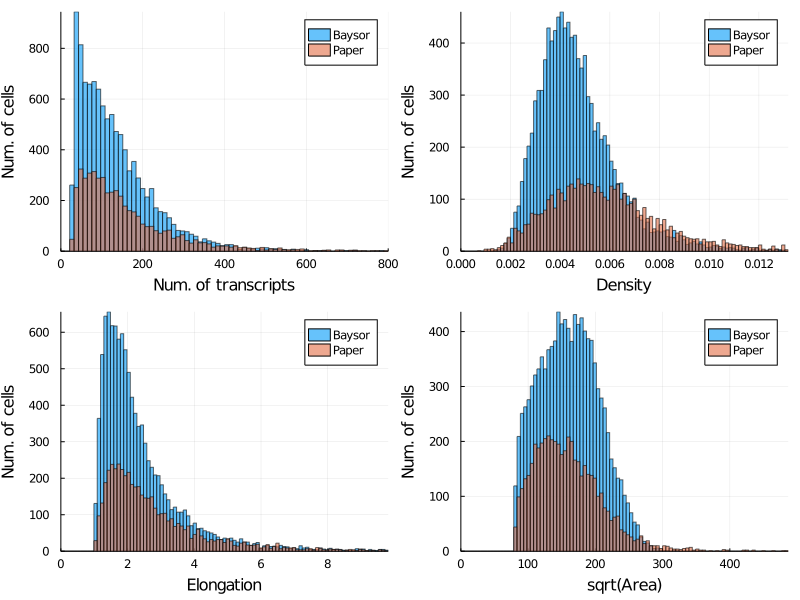

In [8]:
BA.plot_qc_comparison([data[:qc_per_cell_dfs][k] for k in cell_cols]; max_quants=[1, 0.99, 0.99, 0.999, 0.99], 
    labels=["Baysor", "Paper"])

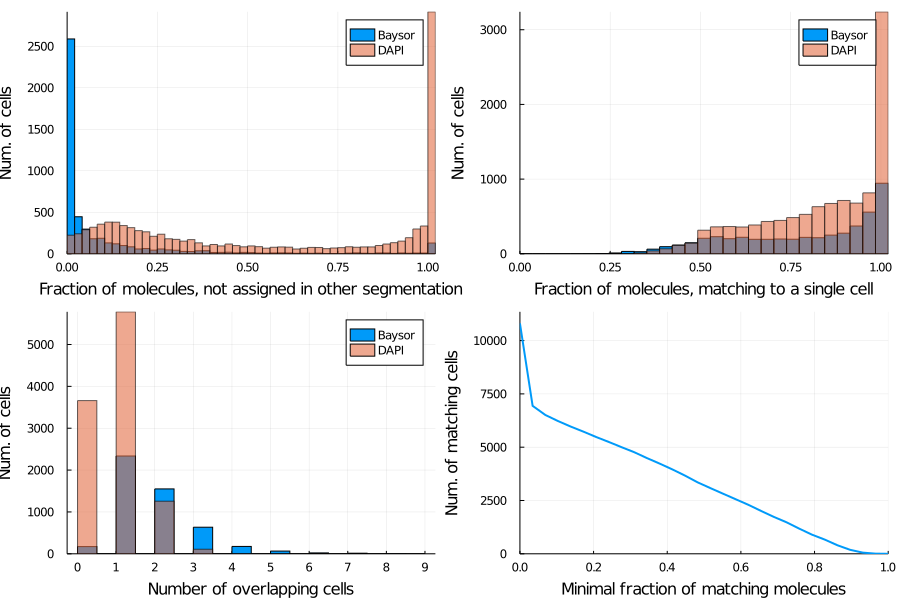

In [9]:
BA.plot_matching_comparison(data[:match_res_paper_cell])

## Analyze embeddings

### Embeddings

In [17]:
@time cms = Dict(cq => B.convert_segmentation_to_counts(data[:df].gene, data[:df][!, cq])[:, qdf.cell_id] for (cq, qdf) in data[:qc_per_cell_dfs]);
@time umaps, umap_merged, cm_merged = BA.estimate_embedding([cms[k] for k in cell_cols]...; n_pcs=20, metric=Euclidean(), spread=4);

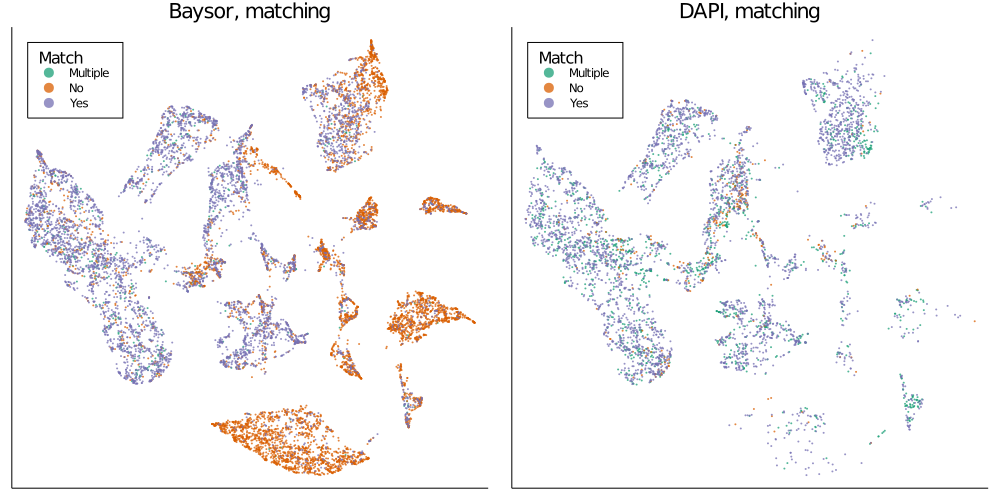

In [22]:
BA.plot_qc_embeddings([data[:qc_per_cell_dfs][k] for k in cell_cols], data[:match_res_cell_paper], umaps, legend=:topleft, size=(1000, 500), 
    plot_num_transcripts=false, layout=(1,2), palette=ColorSchemes.Dark2_3, ms=1.5, alpha=0.75, ticks=false)

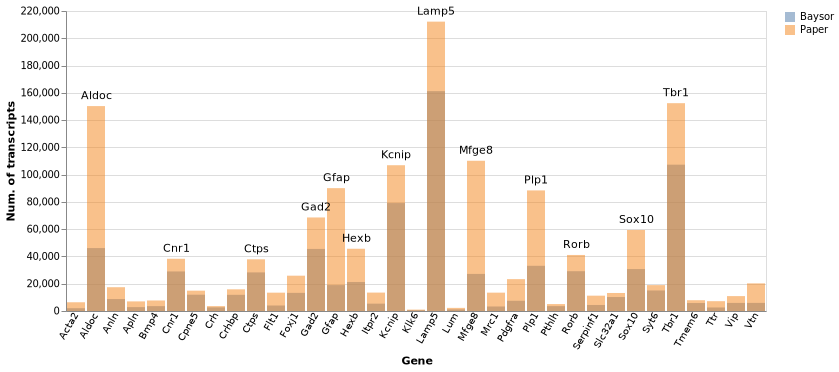

In [11]:
BA.plot_expression_vec_comparison(data[:df], data[:qc_per_cell_dfs], data[:gene_names], 
    xticks=true, ylabel="Num. of transcripts", labels=["Baysor", "Paper"])

In [12]:
clusts = Clustering.hclust(Distances.pairwise(Euclidean(), B.transform(umap_merged.pca_transform, cm_merged), dims=2); linkage=:ward);

### Annotation

In [13]:
@rimport CellAnnotatoR
R"""
library(Matrix)
library(CellAnnotatoR)
library(magrittr)
library(ggplot2)
library(ggrepel)

theme_set(theme_bw())
""";

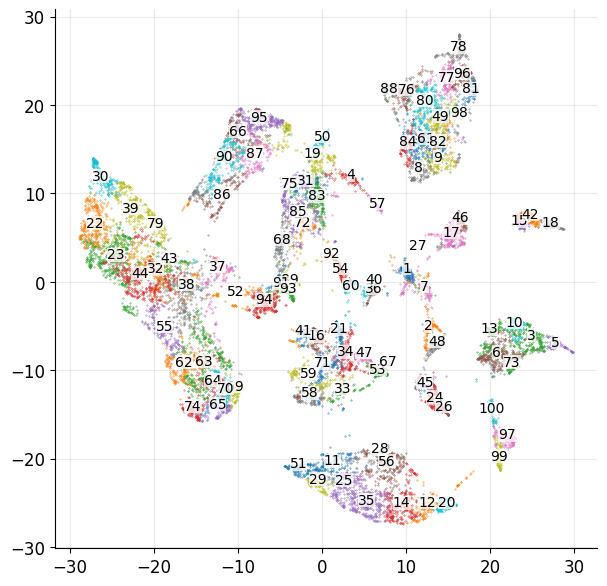

PyObject <AxesSubplot:>

In [23]:
cell_names = ["c$i" for i in 1:size(umap_merged.embedding, 2)];
c_clusts = Clustering.cutree(clusts, k=100)

Plt.figure(figsize=(7, 7))
BA.plot_embedding(umap_merged.embedding, c_clusts, s=0.1)

In [15]:
cm_merged_r = hcat([cms[k] for k in cell_cols]...)
cell_names = ["c$i" for i in 1:R"ncol"(cm_merged_r)[1]]
cm_merged_r = R"`rownames<-`"(cm_merged_r, data[:gene_names]);
cm_merged_r = R"`colnames<-`"(cm_merged_r, cell_names);

cm_norm = CellAnnotatoR.normalizeTfIdfWithFeatures(cm_merged_r);

In [16]:
clf_data = CellAnnotatoR.getClassificationData(cm_norm, projectdir("metadata/markers/somatosensory_osm_fish.txt"), prenormalized=true);
ann_by_level_spatial = rcopy(CellAnnotatoR.assignCellsByScores(nothing, clf_data, verbose=false, clusters=R"setNames"(c_clusts, cell_names)))[:annotation];

┌ Warning: RCall.jl: Warning in expandAnnotationToClusters(scores, clusters) :
│   After cluster expansion, the following types are missed: Macrophages. Possible clusters for increasing resolution: 44, 7, 38, 57, 40, 78, 81, 96, 19, 77, 98, 4, 49, 61, 54, 87, 76, 51, 82, 27, 28, 94, 11, 50
│ Warning in expandAnnotationToClusters(scores, clusters) :
│   After cluster expansion, the following types are missed: Micro Mrc1. Possible clusters for increasing resolution: 18, 15, 42
│ Warning in expandAnnotationToClusters(scores, clusters) :
│   After cluster expansion, the following types are missed: C. Plexus. Possible clusters for increasing resolution: 97, 99, 100
└ @ RCall /home/vpetukhov/.julia/packages/RCall/eRsxl/src/io.jl:160


In [386]:
# emb = R"$(umap_merged.embedding) %>% t() %>% as.data.frame() %>% set_rownames($cell_names)";
# @time R"""
# gg <- CellAnnotatoR::plotSubtypeMarkers($emb, t($cm_norm), clf.data=$clf_data, size=0.2, raster=TRUE, 
#     raster.dpi=150, n.col=4, max.depth=1, plot.na=FALSE)
# ggsave("./osmfish_markers.pdf", width=10, height=25)
# """;
# @time R"""
# gg <- CellAnnotatoR::plotSubtypeMarkers($emb, t($cm_norm), parent.type="Inhibitory", clf.data=$clf_data, size=0.2, raster=TRUE, 
#     raster.dpi=150, n.col=2, max.depth=1, plot.na=FALSE)
# ggsave("./osmfish_markers_subs.pdf", width=8, height=8)
# """;

  1.944233 seconds (223 allocations: 6.141 KiB)


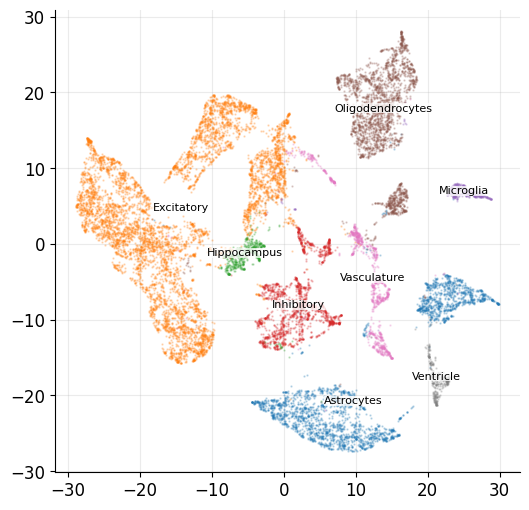

In [24]:
Plt.figure(figsize=(6, 6))
BA.plot_embedding(umap_merged.embedding, ann_by_level_spatial[:l1], s=0.5, alpha=0.25, fontsize=8);

In [30]:
c_annot = ann_by_level_spatial[:l1];
seg_type_per_cell = vcat(repeat([1], inner=size(umaps[1],2)), repeat([2], inner=size(umaps[2], 2)));
annot_labels = sort(unique(c_annot));
n_cells_per_type = [B.count_array(denserank(c_annot)[ids]) for ids in B.split_ids(seg_type_per_cell)];

DataFrame(Dict(:Type => annot_labels, :Frac => 1 .- n_cells_per_type[2] ./ n_cells_per_type[1]))[:, [2,1]]

,Type,Frac
,String,Float64
1,Astrocytes,0.91751
2,Excitatory,0.197051
3,Hippocampus,0.519774
4,Inhibitory,0.415663
5,Microglia,0.886503
6,Oligodendrocytes,0.585819
7,Vasculature,0.82906
8,Ventricle,0.572034


### Plotting annotated data

In [31]:
c_annot = ann_by_level_spatial[:l2];
seg_type_per_cell = vcat(repeat([1], inner=size(umaps[1],2)), repeat([2], inner=size(umaps[2], 2)));
annot_labels = sort(unique(c_annot));
n_cells_per_type = [B.count_array(denserank(c_annot)[ids]) for ids in B.split_ids(seg_type_per_cell)];

missed_props = ["$v" for v in round.(Int, (1 .- n_cells_per_type[2] ./ n_cells_per_type[1]) .* 100)];

p_df = vcat([DataFrame(:n => n, :seg => s, :t => annot_labels) for (n, s) in zip(n_cells_per_type, ["Baysor", "Paper"])]...);

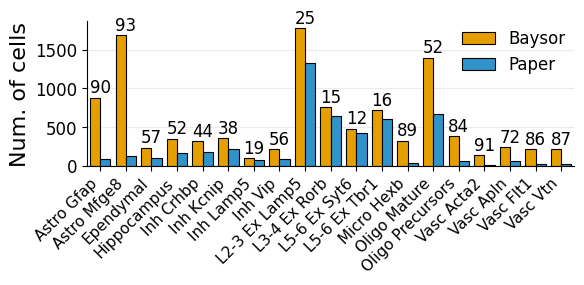

In [299]:
plt = Plt.figure(figsize=(6, 3))
ax = Sns.barplot(x=p_df.t, y=p_df.n, hue=p_df.seg, palette=color_per_label, edgecolor="black", linewidth=0.8, saturation=1)
for (x, y, t) in zip((1:length(annot_labels)) .- 1, max.(n_cells_per_type...), missed_props)
    Plt.annotate(t, (x, y + 60), horizontalalignment="center")
end

ax.set_ylabel("Num. of cells")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11);
Plt.tight_layout()

Plt.savefig(cplotsdir("num_cells_per_type.pdf"), transparent=true)

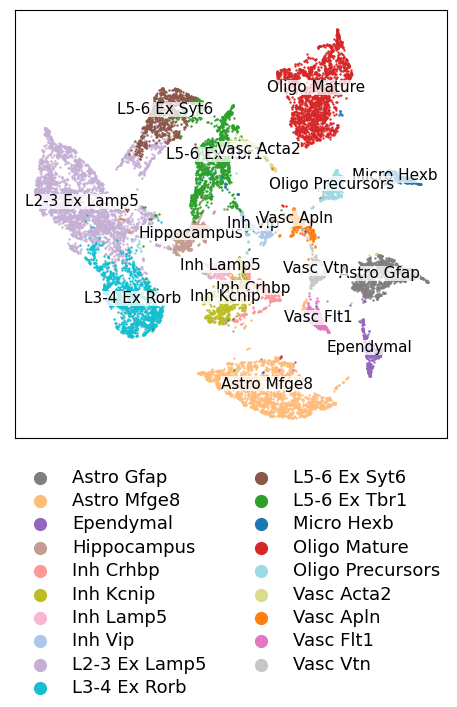

In [300]:
p_cols = Random.shuffle("#" .* Colors.hex.(ColorSchemes.tab20[1:20]));

plt = Plt.figure(figsize=(5, 7.3))
Plt.xticks([]); Plt.yticks([])
ax = BA.plot_embedding(umap_merged.embedding, ann_by_level_spatial[:l2], s=0.5, alpha=1, fontsize=11, palette=p_cols)
ax.spines["right"].set_visible(true); ax.spines["top"].set_visible(true);
leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, 
    markerscale=12, labelspacing=0.3, fontsize=13)
for lh in leg.legendHandles
    lh.set_alpha(1)
end

Plt.tight_layout()
Plt.savefig(cplotsdir("embedding_annot.pdf"), transparent=true)

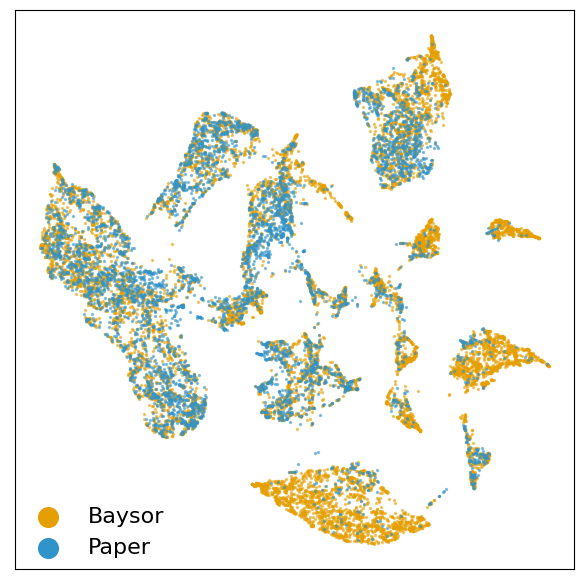

In [240]:
p_cols = [color_per_label[k] for k in ["Baysor", "Paper"]]

plt = Plt.figure(figsize=(6, 6), frameon=true)
Plt.xticks([]); Plt.yticks([])
ax = BA.plot_embedding(umap_merged.embedding, ["Baysor", "Paper"][seg_type_per_cell], s=2, alpha=0.5, 
    mark_groups=false, palette=p_cols)
ax.spines["right"].set_visible(true); ax.spines["top"].set_visible(true);

# ids_per_clust = B.split_ids(denserank(ann_by_level_spatial[:l2]))
# clust_centers = hcat([median(umap_merged.embedding[:, ids], dims=2) for ids in ids_per_clust]...);
# bbox_style = Dict(:facecolor=>"white", :alpha=>0.5, :edgecolor=>"none", :pad=>0.0)
# for (t, x, y) in zip(annot_labels, clust_centers[1,:], clust_centers[2,:])
#     ax.annotate(t, (x,y), horizontalalignment="center", fontsize=8, bbox=bbox_style)
# end

leg = ax.legend(loc="lower left", markerscale=10, fontsize=16)
for lh in leg.legendHandles
    lh.set_alpha(1)
end

Plt.tight_layout()
Plt.savefig(cplotsdir("embedding_source.pdf"), transparent=true)

In [348]:
expr_per_clust = hcat([mean(cm_merged[:, ids] ./ sum(cm_merged[:,ids], dims=1), dims=2) for ids in ids_per_clust]...);
expr_per_clust ./= sum(expr_per_clust, dims=2);
gene_sub = sortperm(maximum(expr_per_clust, dims=2)[:], rev=true)[1:30];

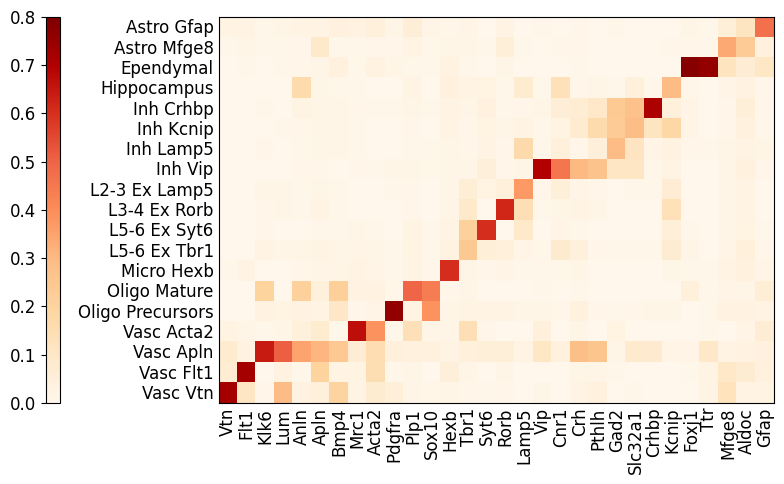

In [353]:
fig, (cax, ax) = Plt.subplots(ncols=2, figsize=(8, 5),  gridspec_kw=Dict("width_ratios" => [0.025, 1]))

BA.clustermap(expr_per_clust[gene_sub, :], data[:gene_names][gene_sub],
    diag_genes=true, cell_ord=1:size(expr_per_clust, 2), cmap=:OrRd, rasterized=true, cbar=false, ax=ax,
    vmin=0.0, vmax=0.8
)

fig.colorbar(ax.get_children()[1], cax=cax, orientation="vertical")
cax.yaxis.set_ticks_position("left")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12, ha="right");
ax.set_yticks(1:length(cell_ord))
ax.set_yticklabels(annot_labels[cell_ord], fontsize=12, rotation=0, va="bottom")
[ax.spines[k].set_visible(true) for k in keys(ax.spines)];

ax.tick_params(axis="both", which="both",length=0)
Plt.tight_layout()
Plt.savefig(cplotsdir("cluster_expression.pdf"), transparent=true)

## Examples

In [146]:
ids_per_clust = B.split_ids(denserank(c_annot)[1:size(umaps[1], 2)]);

t_clusts = findall([mean(data[:match_res_cell_paper].match_noise[1][ids]) for ids in ids_per_clust] .> 0.75);
t_clusts = t_clusts[in.(annot_labels[t_clusts], Ref(["Astro Mfge8", "Micro Hexb"]))]

t_noise_ids = filter.(x -> data[:match_res_cell_paper].match_noise[1][x], ids_per_clust[t_clusts]);

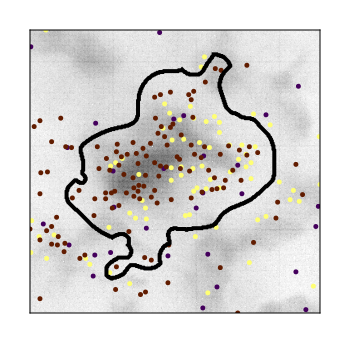

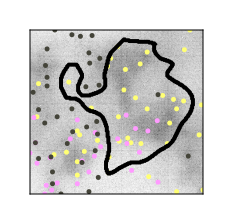

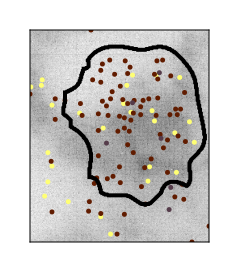

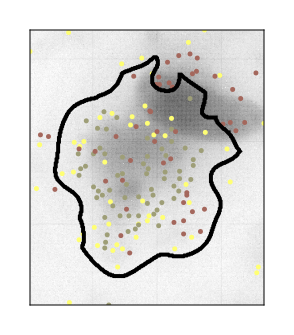

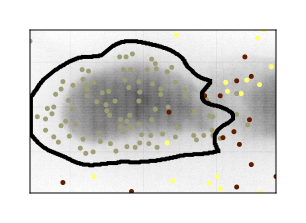

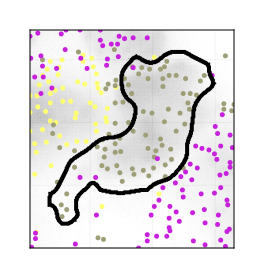

In [317]:
ann_colors = B.distinguishable_colors(data[:gene_names]);
ann_colors = Dict(Pair.(ann_colors[:ticks], ann_colors[:colors]));

for t_ids in t_noise_ids
    n_printed = 0
    for i in t_ids
        n_printed < 3 || break

        cur_cell = data[:qc_per_cell_dfs][:cell].cell_id[i]
        (xs, xe), (ys, ye) = BA.cell_coord_frame(data[:df], cur_cell, offset=0.2);
        
        min(xe - xs, ye - ys) > 200 || continue
        maximum(data[:dapi_arr][ys:ye, xs:xe]) > 0 || continue
        
        c_df = @where(data[:df], :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)
        t_pol = B.boundary_polygons(c_df, ifelse.(c_df.cell .== cur_cell, c_df.cell, 0), bandwidth=15.0, grid_step=1.0, dens_threshold=1e-3)
        if length(t_pol) > 0
            pol_id = findmax(size.(t_pol, 1))[2]
            t_pol = t_pol[pol_id:pol_id]
        end
        
        gene_subs = sortperm(B.count_array(c_df.gene), rev=true)[1:3]
        c_df = @where(c_df, in.(:gene, Ref(gene_subs)))
        f_name = "$(c_annot[i]) $(n_printed + 1)"
        
        for (ext, leg) in ["png" => false, "pdf" => true]
            plt = BA.plot_subset(c_df, data[:dapi_arr], (xs, xe), (ys, ye), annotation=data[:gene_names][c_df.gene], 
                polygons=t_pol, noise=false, polygon_line_width=4.0,
                plot_raw_dapi=false, size_mult=1.0, markersize=5.0, title="", ann_colors=ann_colors, ticks=false,
                legend_kwargs=(position=:lt, labelsize=16, padding=(0,5,0,0), patchlabelgap=1, rowgap=0),
                legend=leg, plot_bg_dapi=!leg)
            MK.save(cplotsdir("examples", "$(f_name).$(ext)"), plt)
            leg || display(plt)
        end
        n_printed += 1
    end
end